## Prerequisites 

In [9]:
# Useful for being able to dump images into the Notebook
import IPython.display as D
# show images inline
%matplotlib inline

# [Custom Vision Service](https://customvision.ai)

![url](http://aihelpwebsite.com/Portals/0/Blog/Files/1/1024/Windows-Live-Writer-5d53ba6d17ba_CCC7-image_dcb1e7bb-3eb3-4e94-a0d1-c04d397fc7f5.png)


Sourced here: https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/python-tutorial and https://www.microsoft.com/developerblog/2017/05/12/food-classification-custom-vision-service/

### Custom Vision Service brings the power of machine learning to your apps
Custom Vision Service is a tool for building custom image classifiers. It makes it easy and fast to build, deploy, and improve an image classifier. We provide a REST API and a web interface to upload your images and train.

### What can Custom Vision Service do well?
Custom Vision Service is a tool for building custom image classifiers, and for making them better over time. For example, if you want a tool that could identify images of "Daisies", "Daffodils", and "Dahlias", you could train a classifier to do that. You do so by providing Custom Vision Service with images for each tag you want to recognize.

![](https://aiplatformsprodstoragecdn.azureedge.net/aiplatformassets/knovuecdl43j/5ISVlvW7MAUwGywyuy2Sm2/a2a712c3717b328e87d325287f675192/custom-vision-details.jpg)

Custom Vision Service works best when the item you are trying to classify is prominent in your image. Custom Vision Service does "image classification" but not yet "object detection." This means that Custom Vision Service identifies whether an image is of a particular object, but not where that object is within the image.

Very few images are required to create a classifier -- 30 images per class is enough to start your prototype. The methods Custom Vision Service uses are robust to differences, which allows you to start prototyping with so little data. However, this means Custom Vision Service is not well suited to scenarios where you want to detect very subtle differences (for example, minor cracks or dents in quality assurance scenarios.)

Custom Vision Service is designed to make it easy to start building your classifier, and to help you improve the quality of your classifier over time.

Developers can also export their models to be run on the edge devices such as [iOS](https://azure.microsoft.com/en-us/blog/custom-vision-service-introduces-classifier-export-starting-with-coreml-for-ios-11/)

# Challenge

## Step 1: Prepare the keys and the images needed for the example
Custom Vision Service can be found by clicking here: https://customvision.ai

Obtain your training and prediction key by logging into the Custom Vision Service and navigating to account settings as shown below.

![](https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/media/csharp-tutorial/training-prediction-keys.png)


## Step 2: Create a Custom Vision Service project

Next we need to programatically make a new custom vision service project using the keys your sourced above.

In [2]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageUrlCreateEntry

ENDPOINT = "https://southcentralus.api.cognitive.microsoft.com"

# Replace with a valid key
training_key = '' #<your training key>
prediction_key = '' #<your prediction key>

trainer = CustomVisionTrainingClient(training_key, endpoint=ENDPOINT)


In [3]:
# Create a new project
print("Creating Beverage Policy Classifier...")
project = trainer.create_project("Beverage Policy Classifier")

Creating Beverage Policy Classifier...


## Step 3: Add tags to your project

Run the following code to create tags for our **Valid** and **Invalid** Examples 

In [4]:
# Make two tags in the new project
valid_tag = trainer.create_tag(project.id, "Valid")
invalid_tag = trainer.create_tag(project.id, "Invalid")

## Step 4: Upload images to the project
To add the images we have to the project, insert the following code after the tag creation. This will upload the image with the corresponding tag.

In [5]:
print ("Adding images...")

import os
from multiprocessing.dummy import Pool as ThreadPool

def upload(filepath):
    with open(filepath, mode="rb") as img_data:
        if "Invalid" in filepath:
            trainer.create_images_from_data(project.id, img_data.read(), [ invalid_tag.id ])
        else:
            trainer.create_images_from_data(project.id, img_data.read(), [ valid_tag.id ])
    print('.', end='')
    
def upload_parallel(filepaths, threads=5):
    pool = ThreadPool(threads)
    results = pool.map(upload, filepaths)
    pool.close()
    pool.join()

valid_dir = "dataset/Beverages/Train/Valid/"
invalid_dir = "dataset/Beverages/Train/Invalid/"
valid_paths = [valid_dir + os.fsdecode(image) for image in os.listdir(os.fsencode(valid_dir))]
invalid_paths = [invalid_dir + os.fsdecode(image) for image in os.listdir(os.fsencode(invalid_dir))]
img_paths = valid_paths + invalid_paths
upload_parallel(img_paths)

print("Added {} images, {} valid, {} invalid.".format(len(img_paths), len(valid_paths), len(invalid_paths)))

Adding images...
....................................................................................................................................................................................Added 180 images, 90 valid, 90 invalid.


## Step 5: Train the project
Now that we've added tags and images to the project, we can train it. This creates the first iteration in the project. We can then mark this iteration as the default iteration.

In [6]:
import time

print ("Training...")
iteration = trainer.train_project(project.id)
while (iteration.status == "Training"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Completed


## Step 6: Evaluate the Model

Now lets evaluate the model on the local test dataset that the service has never seen.

In [7]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient

# Now there is a trained endpoint, it can be used to make a prediction

predictor = CustomVisionPredictionClient(prediction_key, endpoint=ENDPOINT)

project_id = project.id
def predict(filepath):
    with open(filepath, mode="rb") as test_data:
        results = predictor.predict_image(project_id, test_data.read(), iteration.id)
    pred  = max(results.predictions, key=lambda x:x.probability).tag_name
    true ='Invalid' if "Invalid" in filepath else 'Valid'
    print('.', pred , end='')
    return (true, pred)
        
def predict_parallel(filepaths, threads=2):
    pool = ThreadPool(threads)
    results = pool.map(predict, filepaths)
    pool.close()
    pool.join()
    return zip(*results)

test_valid_dir = "dataset/Beverages/Test/Valid/"
test_invalid_dir = "dataset/Beverages/Test//Invalid/"
test_valid_paths = [test_valid_dir + os.fsdecode(image) for image in os.listdir(os.fsencode(test_valid_dir))]
test_invalid_paths = [test_invalid_dir + os.fsdecode(image) for image in os.listdir(os.fsencode(test_invalid_dir))]
test_img_paths = test_valid_paths + test_invalid_paths

y_true, y_pred = predict_parallel(test_img_paths)

. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Valid. Invalid. Valid. Invalid. Valid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid. Invalid

## Step 7: Benchmark

              precision    recall  f1-score   support

     Invalid       1.00      1.00      1.00        30
       Valid       1.00      1.00      1.00        30

   micro avg       1.00      1.00      1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Confusion matrix, without normalization
[[30  0]
 [ 0 30]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


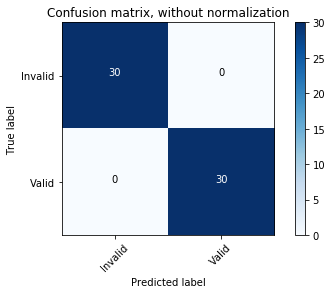

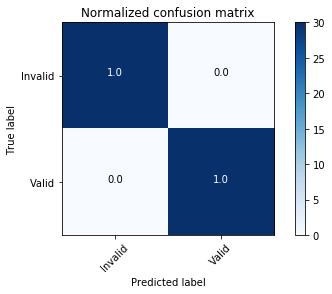

In [10]:
from utils import classification_report
classification_report(y_true, y_pred)

# Conclusions

As you can see the custom vision service is a great tool for generating strong models with relativley small amount of data and little work. In the majority of use cases its a go too tool and a great place to get started.Custom Vision Service works best when the item you are trying to classify is prominent in your image.  

The service is a go to starting point for any classification task. However there are a couple of items to consider when deploying for production.

1) What are the cases that the service fails on (It could be that the 2% error case appears 30% in production or are the most important cases to consider for your use case.

2) How many classes/policies are you classifiying (The models work better with 2-10 policies )

3) What domain is your task?
 